In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
import numpy as np
import os
import time
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


In [2]:
DATASET_PATH='../dataset/preprocesd_cicids.csv'
print(DATASET_PATH)

../dataset/preprocesd_cicids.csv


In [3]:
# ,nrows=10000, header=0
start = time.time()
df=pd.read_csv(DATASET_PATH)
df.head()
print("Time taken to load the data: ", time.time()-start," seconds")

Time taken to load the data:  16.886120080947876  seconds


In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df.shape

(2520798, 79)

In [6]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
              colname = corr_matrix.columns[i]
              col_corr.add(colname)
    return col_corr

In [7]:
corr_features = correlation(df, 0.85)
corr_features

{' Active Min',
 ' Average Packet Size',
 ' Avg Bwd Segment Size',
 ' Avg Fwd Segment Size',
 ' Bwd IAT Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' CWE Flag Count',
 ' ECE Flag Count',
 ' Flow IAT Max',
 ' Fwd Header Length.1',
 ' Fwd IAT Max',
 ' Fwd IAT Mean',
 ' Fwd IAT Min',
 ' Fwd IAT Std',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 ' Idle Max',
 ' Idle Min',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' SYN Flag Count',
 ' Subflow Bwd Bytes',
 ' Subflow Bwd Packets',
 ' Subflow Fwd Bytes',
 ' Total Backward Packets',
 ' Total Length of Bwd Packets',
 ' act_data_pkt_fwd',
 ' min_seg_size_forward',
 'Fwd IAT Total',
 'Fwd Packets/s',
 'Idle Mean',
 'Subflow Fwd Packets'}

In [8]:
df.drop(corr_features,axis=1,inplace=True)

In [9]:
df.shape

(2520798, 44)

In [10]:
# create a Series with the count of rows in each group
label_counts = df[' Label'].value_counts()

# create a list of labels that have less than 10,000 rows
labels_to_merge = label_counts[label_counts < 3000].index.tolist()
print(labels_to_merge)

['Bot', 'Web Attack � Brute Force', 'Web Attack � XSS', 'Infiltration', 'Web Attack � Sql Injection', 'Heartbleed']


In [11]:
# create a new label called 'Other' and merge the labels with less than 10,000 rows
df[' Label'] = df[' Label'].apply(lambda x: 'Other' if x in labels_to_merge else x)
# group the rows by the new 'Label' column
grouped_df = df.groupby(' Label')

In [12]:
df.shape

(2520798, 44)

In [13]:
df[' Label'].value_counts()

 Label
BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
Other                  4138
SSH-Patator            3219
Name: count, dtype: int64

In [14]:
x = df.drop([' Label'],axis=1)
y = df[' Label']

In [15]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(x, y)
Xn, yn = rus.fit_resample(x, y)
# Xn.value_counts()

In [16]:
Xn.shape

(32190, 43)

In [17]:
yn.shape

(32190,)

In [18]:
yn.value_counts()

 Label
BENIGN              3219
DDoS                3219
DoS GoldenEye       3219
DoS Hulk            3219
DoS Slowhttptest    3219
DoS slowloris       3219
FTP-Patator         3219
Other               3219
PortScan            3219
SSH-Patator         3219
Name: count, dtype: int64

In [19]:
#z-score   z = (x - mean) / std
# it can make it easier for the algorithm to learn meaningful patterns in the data
cols = list(Xn.columns)
for col in cols:
    Xn[col] = stats.zscore(Xn[col])

In [20]:
Xn.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,...,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Idle Std
1029337,-0.263616,-0.707781,-0.069969,-0.037641,-0.278349,0.352479,-0.530286,2.687514,-0.022664,-0.158127,...,NaN,NaN,NaN,NaN,-1.116079,-0.276731,-0.332643,-0.198419,-0.342221,-0.280617
2454275,5.566419,-0.709415,-0.120401,-0.042799,-0.324996,-0.115027,-0.563196,-0.188982,-0.023023,0.067566,...,NaN,NaN,NaN,NaN,-1.052714,-0.244825,-0.332643,-0.198419,-0.342221,-0.280617
440854,-0.260863,2.309030,0.131756,-0.023235,0.247642,-0.115027,-0.442882,-0.188982,-0.023022,-0.159054,...,NaN,NaN,NaN,NaN,-0.543073,0.380396,-0.306772,-0.168252,-0.277858,-0.278543
438438,-0.223847,-0.561542,-0.002728,-0.025147,0.022447,-0.115027,-0.046554,-0.188982,-0.022969,-0.159033,...,NaN,NaN,NaN,NaN,-0.543073,-0.260084,-0.182565,-0.198419,-0.218966,-0.280617
2307425,-0.263616,-0.708802,-0.120401,-0.040664,-0.247787,0.658776,-0.517901,3.770066,-0.022467,-0.158233,...,NaN,NaN,NaN,NaN,-1.116079,-0.276731,-0.332643,-0.198419,-0.342221,-0.280617


In [21]:
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert the labels to integers
label_encoder = LabelEncoder()
yn = label_encoder.fit_transform(yn)

#spliting the data set

X_train, X_test, Y_train, Y_test = train_test_split(Xn,yn,test_size=0.20,random_state=0)

In [22]:
print(np.any(np.isnan(X_train)))
print(np.all(np.isfinite(X_train)))

True
False


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create an instance of SimpleImputer with 'mean' strategy to replace NaN values
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to X_train and transform X_train and X_test with it
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply StandardScaler to X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\DUT\Nam5\Ky9\ATTT\venvattt\lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [' Bwd PSH Flags' ' Fwd URG Flags' ' Bwd URG Flags' 'Fwd Avg Bytes/Bulk'
 ' Fwd Avg Packets/Bulk' ' Fwd Avg Bulk Rate' ' Bwd Avg Bytes/Bulk'
 ' Bwd Avg Packets/Bulk' 'Bwd Avg Bulk Rate']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\DUT\Nam5\Ky9\ATTT\venvattt\lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [' Bwd PSH Flags' ' Fwd URG Flags' ' Bwd URG Flags' 'Fwd Avg Bytes/Bulk'
 ' Fwd Avg Packets/Bulk' ' Fwd Avg Bulk Rate' ' Bwd Avg Bytes/Bulk'
 ' Bwd Avg Packets/Bulk' 'Bwd Avg Bulk Rate']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [32]:
from keras.models import Sequential
from keras.layers import Dense
#training our model using Neural network classifire

# Define the model architecture
start = time.time()
model = Sequential()
model.add(Dense(units=64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32)

print("Time taken to train model: ", time.time()-start," seconds")

Epoch 1/50


c:\DUT\Nam5\Ky9\ATTT\venvattt\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7411 - loss: 1.0044
Epoch 2/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9413 - loss: 0.2133
Epoch 3/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9565 - loss: 0.1582
Epoch 4/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9646 - loss: 0.1274
Epoch 5/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9706 - loss: 0.1120
Epoch 6/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9735 - loss: 0.1005
Epoch 7/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9737 - loss: 0.0918
Epoch 8/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9754 - loss: 0.0863
Epoch 9/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9773 - loss: 0.0787
Epoch 10/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9780 - loss: 0.0750
Epoch 11/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0779
Epoch 12/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,952 (54.50 KB)

 Trainable params: 4,650 (18.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,302 (36.34 KB)

In [34]:
# Performance metrics for train data
start = time.time()
Predict_X_train = model.predict(X_train).argmax(axis=1)
accuracy_train = metrics.accuracy_score(Y_train, Predict_X_train)
confusion_matrix_train = metrics.confusion_matrix(Y_train, Predict_X_train)
classification_train = metrics.classification_report(Y_train, Predict_X_train, digits=3)
print("Time taken for test metrics calculation:", time.time() - start, "seconds")

print("\n--------------------------- Test Results ---------------------------\n")
print("Model Accuracy:\n", accuracy_train)
print("Confusion Matrix:\n", confusion_matrix_train)
print("Classification Report:\n", classification_train)

805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Time taken for test metrics calculation: 1.3649961948394775 seconds

--------------------------- Test Results ---------------------------

Model Accuracy:
 0.9852050326188257
Confusion Matrix:
 [[2399    9    0   40    1    4    2   69   41   16]
 [   0 2601    0    0    0    0    0    0    0    0]
 [   0    0 2566    3    1    1    0    1    0   17]
 [   0    0    0 2582    0    0    0    0    0    2]
 [   1    0    4    0 2541    9    0    2    0    6]
 [   4    0    1    1    7 2578    0    1    0    1]
 [   0    0    0    4    0    3 2491    0    0    1]
 [   7    0    9   11    0    0    0 2476    1   82]
 [   0    0    0    2    0    1    0    1 2552    0]
 [   0    0    0    5    0    2    8    0    0 2585]]
Classification Report:
               precision    recall  f1-score   support

           0      0.995     0.929     0.961      2581
           1      0.997     1.000     0.998      2601
           2      0.995     0.991     0.993    

In [35]:
def plot_confusion_matrix(cm,title,cmap=None,target=None,normalize=False):

    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target is not None:
        ticks = np.arange(len(target))
        plt.xticks(ticks, target, rotation=45)
        plt.yticks(ticks, target)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title, bbox_inches='tight', dpi=300)

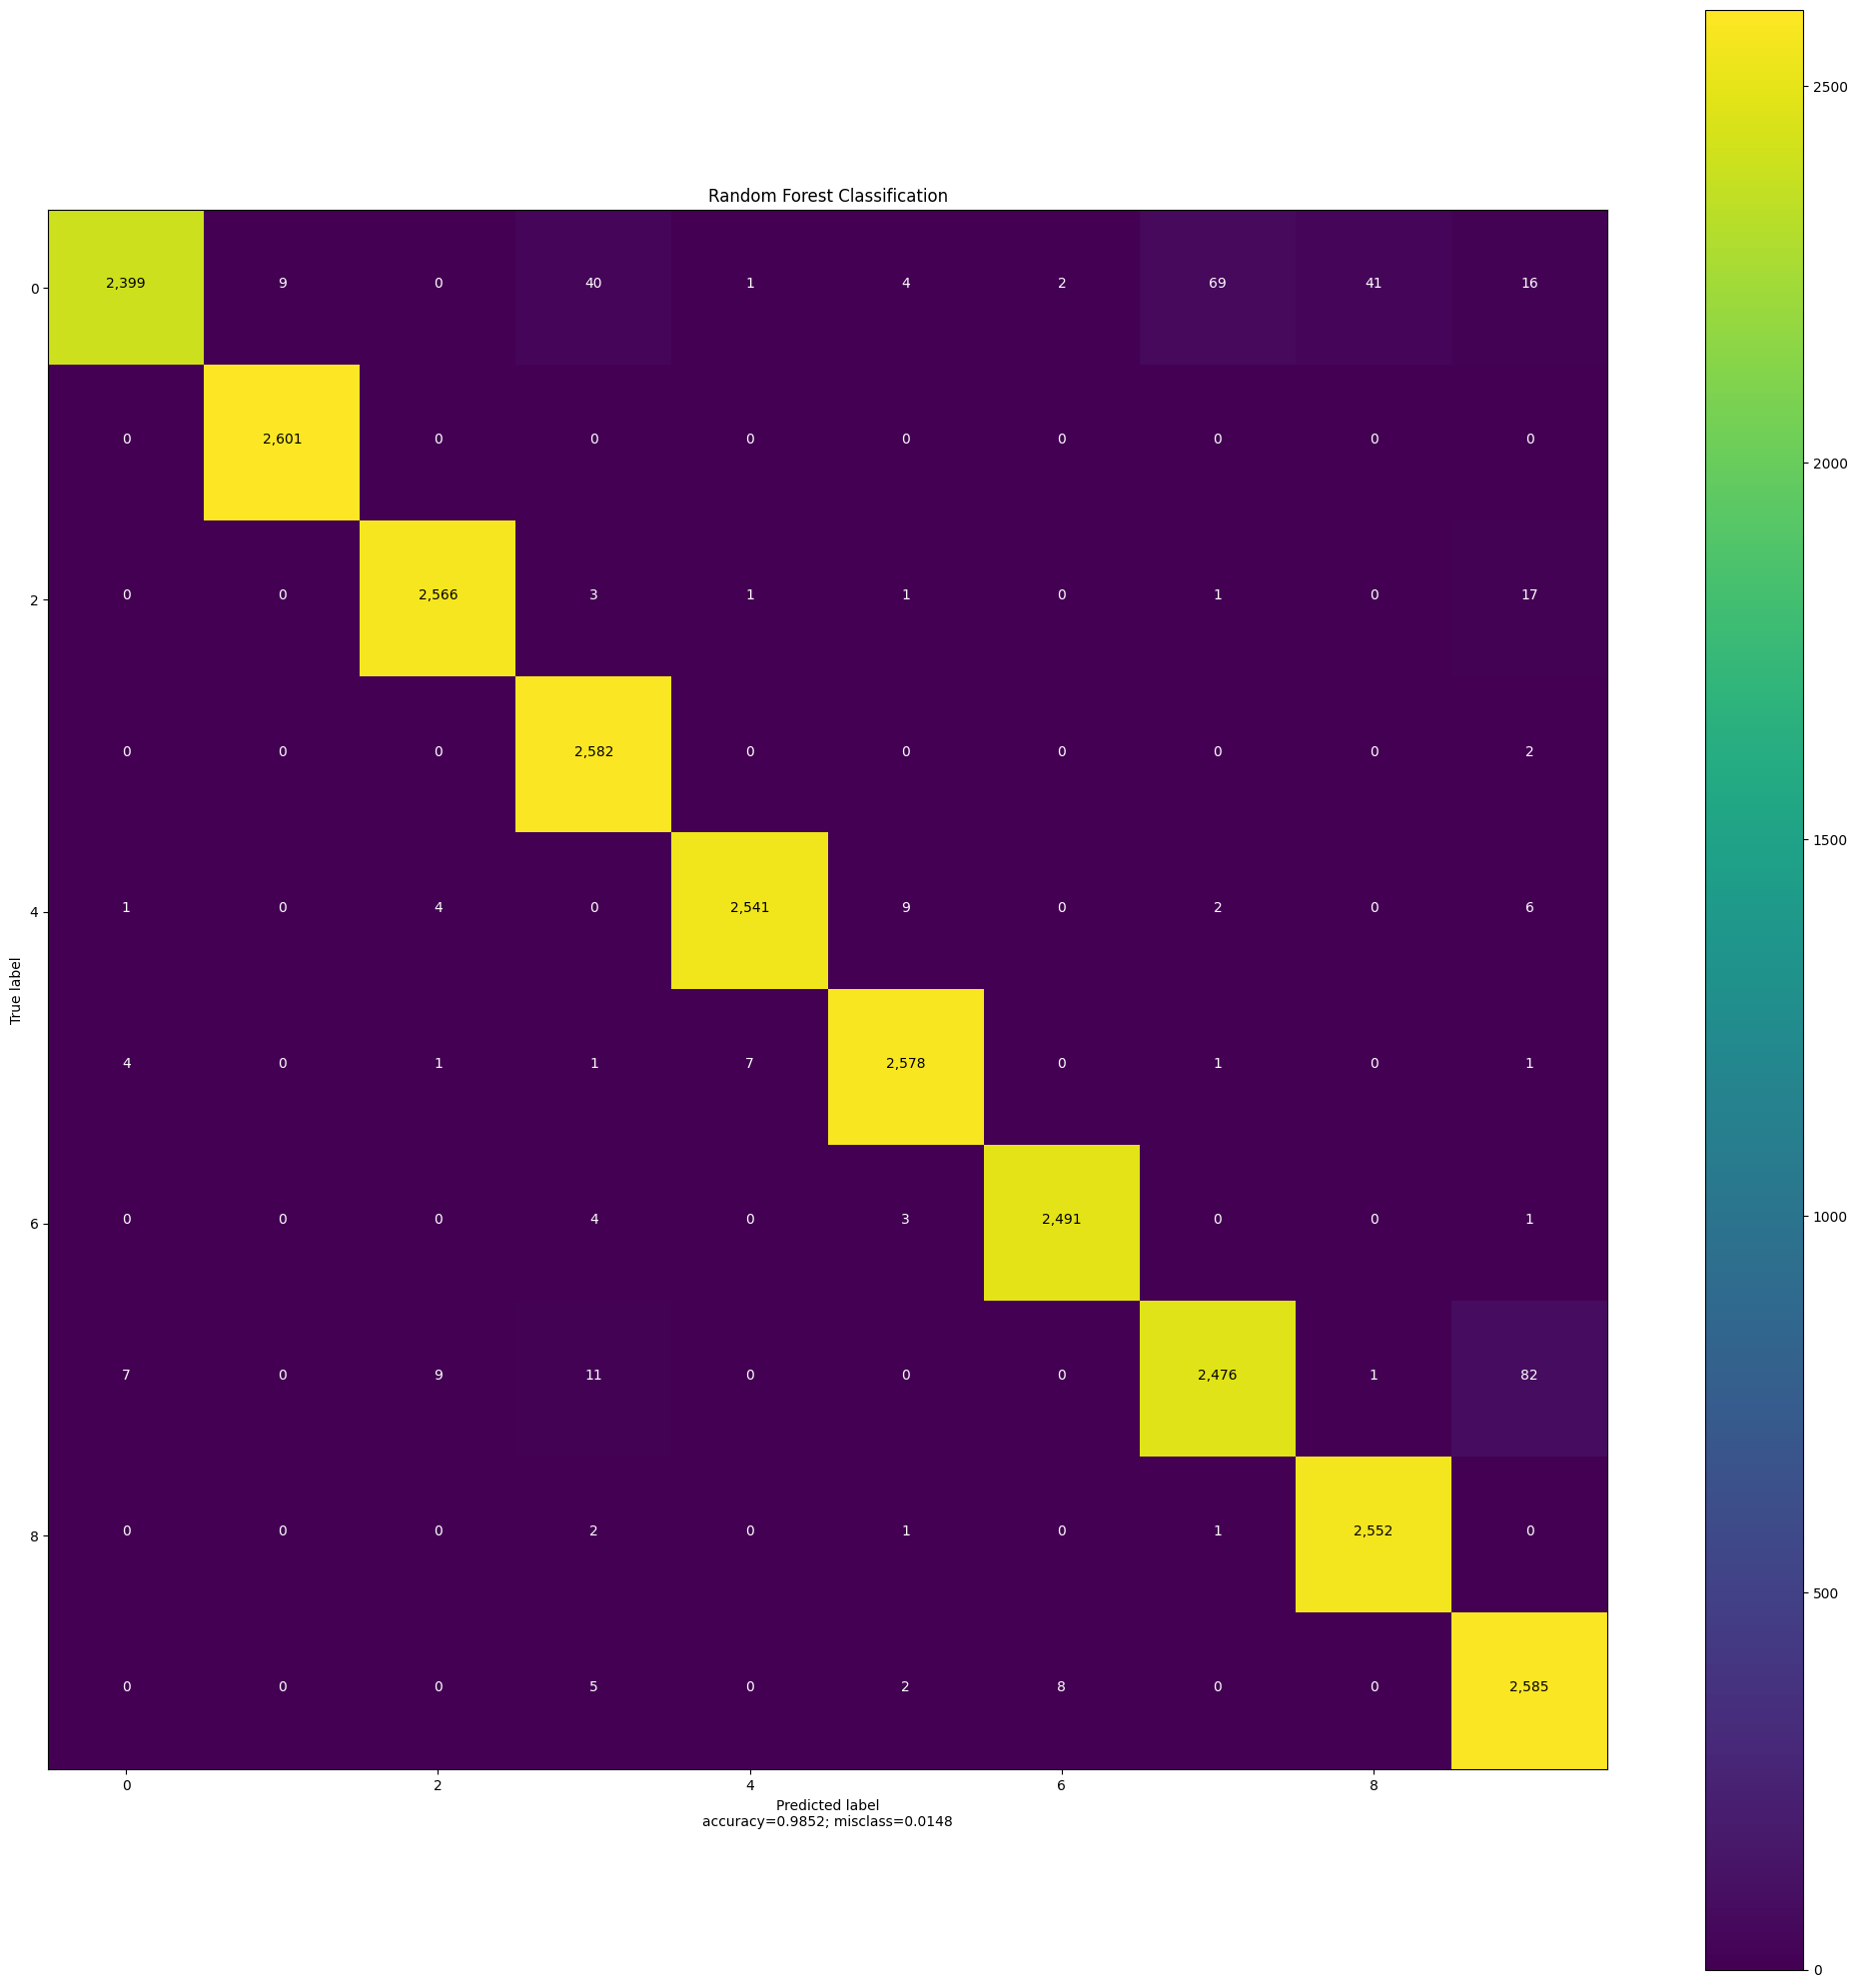

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_confusion_matrix(cm=confusion_matrix_train ,title= 'Random Forest Classification')

In [37]:
# Performance metrics for test data
start = time.time()
Predict_X_test = model.predict(X_test).argmax(axis=1)
accuracy_test = metrics.accuracy_score(Y_test, Predict_X_test)
confusion_matrix_test = metrics.confusion_matrix(Y_test, Predict_X_test)
classification_test = metrics.classification_report(Y_test, Predict_X_test, digits=3)
print("Time taken for test metrics calculation:", time.time() - start, "seconds")

print("\n--------------------------- Test Results ---------------------------\n")
print("Model Accuracy:\n", accuracy_test)
print("Confusion Matrix:\n", confusion_matrix_test)
print("Classification Report:\n", classification_test)

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Time taken for test metrics calculation: 0.42604970932006836 seconds

--------------------------- Test Results ---------------------------

Model Accuracy:
 0.983224603914259
Confusion Matrix:
 [[592   3   1  11   1   6   0  10  10   4]
 [  2 616   0   0   0   0   0   0   0   0]
 [  0   0 629   0   0   0   0   0   0   1]
 [  1   0   1 633   0   0   0   0   0   0]
 [  2   0   0   0 645   7   0   1   0   1]
 [  1   0   0   0   4 619   0   2   0   0]
 [  0   0   0   1   0   0 718   0   0   1]
 [  4   0   3   5   0   1   0 601   0  19]
 [  0   0   0   1   0   0   0   0 662   0]
 [  0   0   0   0   0   0   4   0   0 615]]
Classification Report:
               precision    recall  f1-score   support

           0      0.983     0.928     0.955       638
           1      0.995     0.997     0.996       618
           2      0.992     0.998     0.995       630
           3      0.972     0.997     0.984       635
           4      0.992     0.983     0

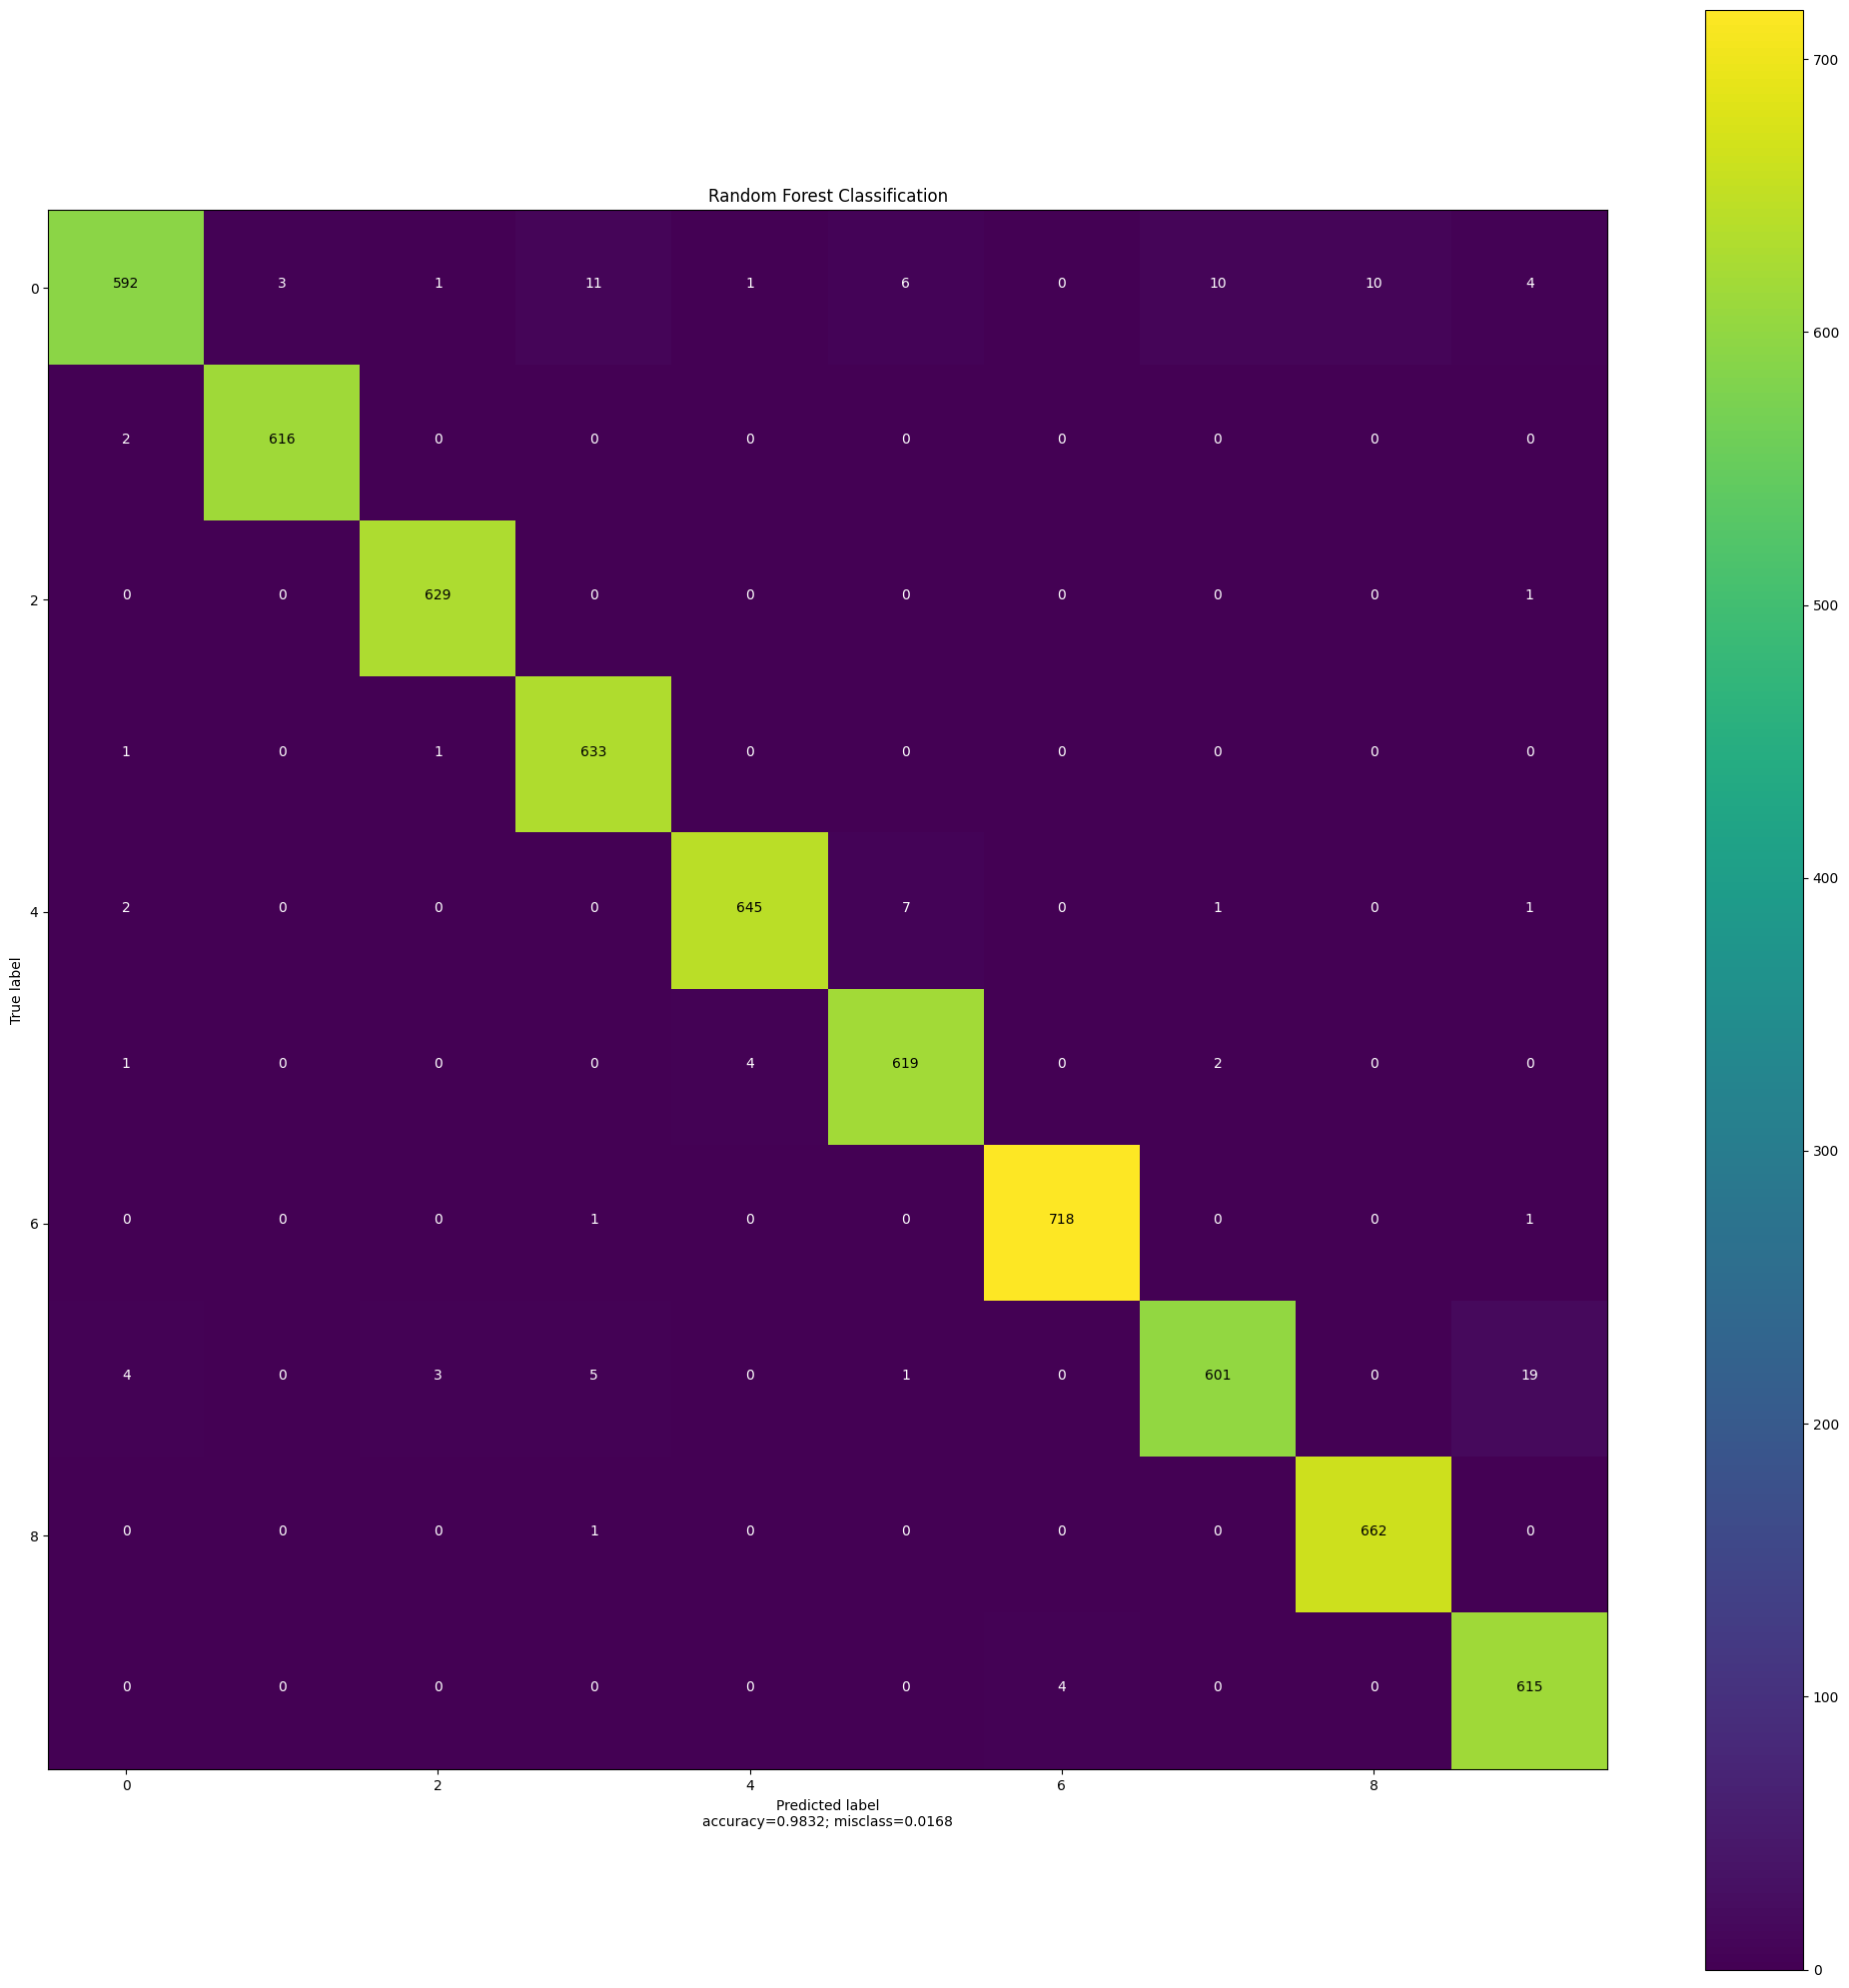

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_confusion_matrix(cm=confusion_matrix_test ,title= 'Random Forest Classification')

In [41]:
model.save("neural_network_model.keras")